In [1]:
do_savefig = false
figures_dir = "insert/path/where/figures/should/be/saved/"
data_dir = "../Mississippi_data"
;

In [2]:
using LaTeXStrings
using GaussianProcesses
using Distributions
using Base.LinAlg
using Distances
using LibGEOS
import IterTools
using GeoInterface
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=200.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=200.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [3]:
X_LA =      readcsv(joinpath(data_dir, "X_LA.csv"))
X_MS =      readcsv(joinpath(data_dir, "X_MS.csv"))
LA_dist =   readcsv(joinpath(data_dir, "LA_Dist.csv"))
MS_dist =   readcsv(joinpath(data_dir, "MS_Dist.csv"))
sentinels = readcsv(joinpath(data_dir, "sentinels.csv"))
border =    readcsv(joinpath(data_dir, "border.csv"))
;

In [4]:
n_MS = size(X_MS, 2)
n_LA = size(X_LA, 2)

64

In [5]:
border_geom = LibGEOS.LineString([border[i,:] for i in 1:size(border, 1)])

LibGEOS.LineString(Ptr{Ptr{Void}} @0x00007fe86fc69190)

In [6]:
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

7-element Array{String,1}:
 "#E69F00"
 "#56B4E9"
 "#009E73"
 "#F0E442"
 "#0072B2"
 "#D55E00"
 "#CC79A7"

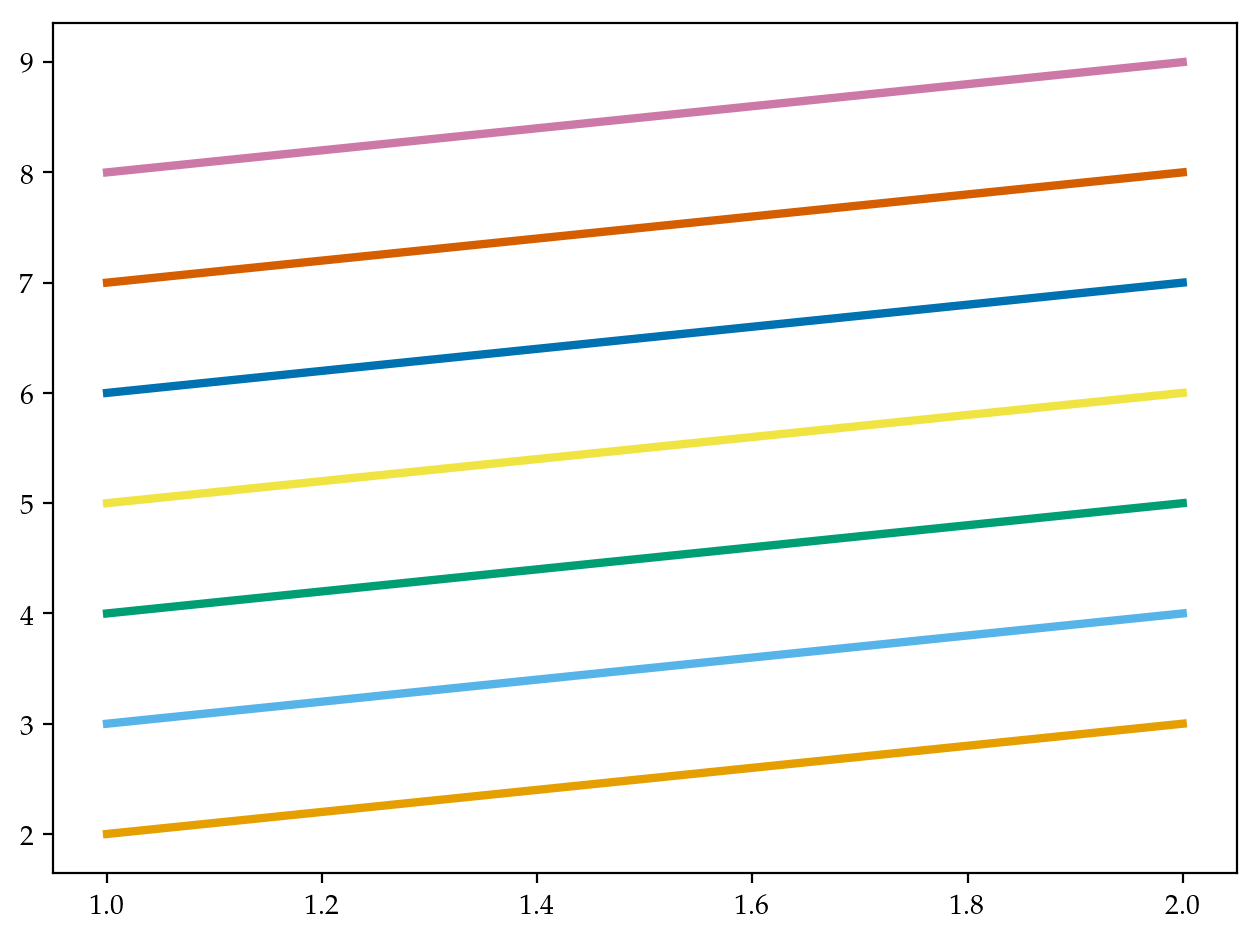

In [7]:
for (i,c) in enumerate(cbbPalette)
    plt.plot((1,2), [1,2]+i, color=c, linewidth=3)
end

In [8]:
Δ = 50e3
AΔ = LibGEOS.buffer(border_geom, Δ)

AΔ_coords = GeoInterface.coordinates(AΔ)[1]
AΔ_hcat = hcat(AΔ_coords...)
;

In [9]:
_xlim = (-1.03e7, -1.005e7)
_ylim = (3.55e6, 3.72e6)

(3.55e6, 3.72e6)

In [10]:
function arrow_distance(xy_start, xy_end, text; 
        color="black", 
        offset=(5, 5), 
        arrow_size=5.0, 
        shrink=0.0, 
        linewidth=2.0)
    plt.annotate(
        "", 
        xy=tuple(xy_start...),
        xycoords="data",
        xytext=tuple(xy_end...),
        textcoords="data",
#         shrink=1.0,
        arrowprops=Dict(:arrowstyle => "<->", 
                        :linewidth => linewidth,
                        :color => color,
                        :shrinkA => shrink,
                        :shrinkB => shrink,
                        :mutation_scale => arrow_size,
#                         "frac" => 0.05,
#                         "shrink" => 0.5,
                        ),
        zorder=10)
    text_xy = tuple(((xy_start.+xy_end)/2)...)
    plt.annotate(
        text, 
        xy=text_xy, 
        xycoords="data",
        xytext=offset, 
        textcoords="offset points",
        arrowprops=Dict(
            "color" => color,
            "arrowstyle" => "-",
            "linewidth" => 0.0,
        ),
        color=color,
        zorder=10,
        )
end

# plot border
function plot_common(;arrow_delta=true, label_border=true, label_vicinity=true, label_obs=true)    
    iB_inxlim = _xlim[1] .< border[:,1] .< _xlim[2]
    iB_inylim = _ylim[1] .< border[:,2] .< _ylim[2]
    iB_inxy = iB_inxlim .& iB_inylim
    border_inxy = border[iB_inxy, :]
    plt.plot(border[:,1], border[:,2], "-", color="#555555")
    if label_border
        iannotate = 50
        plt.annotate(L"$\mathcal{B}$",
                (border_inxy[iannotate, 1], 
                 border_inxy[iannotate, 2]),
                xycoords="data",
                xytext=(5, 5), 
                textcoords="offset points",
                color="#555555",
        )
    end

    if label_obs
        label="Observation (MS)"
    else
        label=""
    end
    # plot county centroids
    plt.scatter(
            X_MS[1,:], 
            X_MS[2,:], 
            marker="o", 
            color="none", 
            edgecolor=cbbPalette[2], 
            label=label,
            s=20)
    if label_obs
        label="Observation (LA)"
    else
        label=""
    end
    plt.scatter(
            X_LA[1,:], 
            X_LA[2,:], 
            marker="o", 
            color="none", 
            edgecolor=cbbPalette[3], 
            label=label,
            s=20)
    
    ax = plt.gca()

    # BUFFER ZONE
    if label_vicinity
        label = L"Border vicinity $\mathcal{A}_{\Delta}$"
    else
        label = ""
    end
    AΔ_patch = plt.matplotlib[:patches][:Polygon](AΔ_coords, 
        true, # closed
        color=cbbPalette[6], 
        alpha=0.2, 
        label=label,
        zorder=-10)
    ax[:add_patch](AΔ_patch)

    if arrow_delta
        # Draw an arrow indicating Δ
        iAΔ_inxlim = _xlim[1] .< AΔ_hcat[1,:] .< _xlim[2]
        iAΔ_inylim = _ylim[1] .< AΔ_hcat[2,:] .< _ylim[2]
        iAΔ_inxy = iAΔ_inxlim .& iAΔ_inylim
        AΔ_inxy = AΔ_hcat[:, iAΔ_inxy]
        arrow_start_xy = AΔ_inxy[:, 50]
        arrow_start_point = LibGEOS.Point(arrow_start_xy...)
        arrow_end_point = LibGEOS.nearestPoints(border_geom, arrow_start_point)[1]
        arrow_end_xy = GeoInterface.coordinates(arrow_end_point)[1:2]
        arrow_distance(
                arrow_start_xy, 
                arrow_end_xy, 
                L"$\Delta$",
                color=cbbPalette[6],
                offset=(5, 0),
                arrow_size=10,
                linewidth=1.0,
                )
    end

    plt.xlim(_xlim)
    plt.ylim(_ylim)
#     ax[:axes][:set_aspect]("equal", "datalim")
end

function plot_proj_line(x, y, proj_x, proj_y, label)
    plt.plot([x, proj_x], [y, proj_y], 
        color="black", alpha=0.05, linewidth=1,
        label=label,
        zorder=-10)
end
;

In [11]:
function plot_finite_proj(X, border_geom; labeled=false, labeled_sent=false, ilabel=1)
    n_X = size(X, 2)
    for i in 1:n_X
        # obtain coordinates for treatment point
        x, y = X[:,i]
        point = LibGEOS.Point(x,y)
        # projection onto border (as distance along border)
        proj_point = nearestPoints(border_geom, 
                                   point)[1]
        # skip if far away from border
        if LibGEOS.distance(point, proj_point) > Δ
            continue
        end

        if !labeled
            label="Projection line"
            labeled=true
        else
            label=""
        end
        proj_x, proj_y = GeoInterface.coordinates(proj_point)
        plot_proj_line(x, y, proj_x, proj_y, label)
        if !labeled_sent
            label="Projected sentinel"
            labeled_sent=true
        else
            label=""
        end     
        plt.scatter(proj_x, proj_y, 
            marker="D", 
            color="#222222", 
            s=5,
            label=label,
            zorder=5)
        
        if i==ilabel
            darkgreen = "#053021"
            plt.annotate(
                L"$\mathbf{s}_i$",
                xy=(x, y), 
                xycoords="data",
                xytext=(5,15), 
                horizontalalignment="left",
                verticalalignment="bottom",
                textcoords="offset points",
                arrowprops=Dict(
                    :arrowstyle => "-",
                    :linewidth => 1.0,
                    :connectionstyle => "arc3,rad=0.3",
                    :color => darkgreen,
                    :linestyle => "dotted",
                    :shrinkA => 0.0,
                    :shrinkB => 5.0,
                ),
                color=darkgreen,
                zorder=10,
                )
            text = arrow_distance(
                [x, y],
                [proj_x, proj_y],
                L"$\mathrm{dist}_\mathcal{B}\left(\mathbf{s}_i\right)$";
                color=darkgreen,
                linewidth=1.0,
                offset=(-13,5),
                arrow_size=8,
                )
            angle = atand((y-proj_y)/(x-proj_x))
            text[:set_rotation](angle)
            
            plt.annotate(
                L"$\mathrm{proj}_\mathcal{B}\left(\mathbf{s}_i\right)$",
                xy=(proj_x, proj_y), 
                xycoords="data",
                xytext=(-15,-15), 
                textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="top",
                arrowprops=Dict(
                    :arrowstyle => "-",
                    :linewidth => 1.0,
                    :connectionstyle => "arc3,rad=0.3",
                    :color => darkgreen,
                    :linestyle => "dotted",
                    :shrinkA => 0.0,
                    :shrinkB => 5.0,
                ),
                color=darkgreen,
                zorder=10,
                )
                
        end
    end
end

function plot_finite_pop()
    # plot projections
    labeled=false
    labeled_sent=false
    plot_finite_proj(X_MS, border_geom)
    plot_finite_proj(X_LA, border_geom; labeled=true, labeled_sent=true, ilabel=58)
end
;

In [12]:
function plot_grid()
    gridspace = 1e4
    X_grid = _xlim[1]:gridspace:_xlim[2]
    Y_grid = _ylim[1]:gridspace:_ylim[2]
    
    arrow_y = 0.7*Y_grid[13] + 0.3*Y_grid[14]
    arrow_distance(
        [X_grid[20], arrow_y],
        [X_grid[21], arrow_y],
        L"$\nu$",
        color=cbbPalette[5],
        offset=(-1, 4),
        shrink=0.0,
        linewidth=1.0,
        )
        
    
    projected_weights = Dict{LibGEOS.Point, Float64}()
    labeled = false
    for (x, y) in IterTools.product(X_grid, Y_grid)
        # convert to a point obejct
        point = LibGEOS.Point(x, y)
        # project the point onto the border
        proj_point = nearestPoints(border_geom, 
                                       point)[1]
        # Only keep points that are both within `maxdist` of
        # the border, and are in the convex hull of the data.
        if LibGEOS.distance(point, proj_point) > Δ
            continue
        end
        proj_x, proj_y = GeoInterface.coordinates(proj_point)
        if !labeled
            label=""
            grid_label=L"grid $G^\nu$"
            labeled=true
        else
            label=""
            grid_label=""
        end
        plt.scatter(
                x, 
                y, 
                s=6, 
                marker="x", 
                color=cbbPalette[5], 
                label=grid_label)
        plot_proj_line(x, y, proj_x, proj_y, label)
        # obtain the coordinates of the projected point
        proj_coords = [proj_x, proj_y]
        found_nearby = false
        for p in keys(projected_weights)
            if LibGEOS.distance(p, proj_point) < 2000.0
                projected_weights[p] += 1.0
                found_nearby = true
                break
            end
        end
        if !found_nearby
            # initialize
            projected_weights[proj_point] = 1.0
        end
    end
    unique_projected_points = [GeoInterface.coordinates(p) for p in keys(projected_weights)]
    Xb_projected = [[p[1] for p in unique_projected_points]';
                    [p[2] for p in unique_projected_points]']
    # And the counts as the weights.
    weights = collect(values(projected_weights))

    plt.scatter(
            Xb_projected[1,:], Xb_projected[2, :],
            s=5.*weights,
            marker="D",
            color="black",
            linewidths=0.0,
            alpha=1.0,
            zorder=5,
            label="",
            )
end
;

In [13]:
function title_in_axis(s, leftright)
    if leftright == :left
        plt.text(0.05, 0.95, s,
             horizontalalignment="left",
             verticalalignment="top",
             transform = plt.gca()[:transAxes])
    elseif leftright == :right
        plt.text(0.95, 0.95, s,
             horizontalalignment="right",
             verticalalignment="top",
             transform = plt.gca()[:transAxes])
    else
        throw("left or right?")
    end
end
;

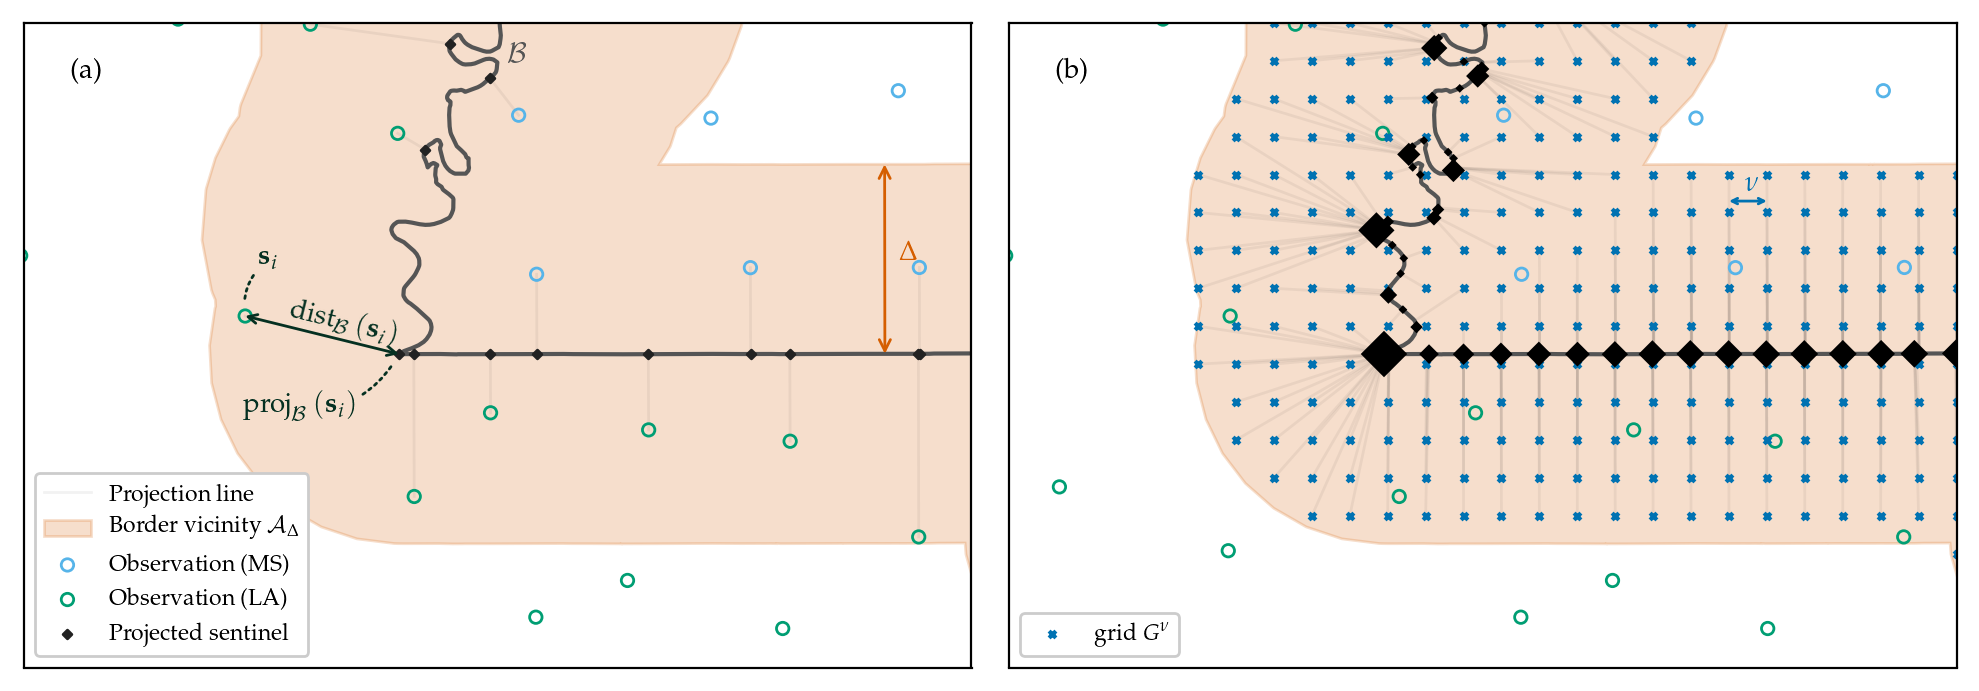

In [14]:
plt.gcf()[:set_size_inches](10, 5)

plt.subplot(1,2,1)
plot_common()
plot_finite_pop()
leg = plt.legend(loc="lower left", fontsize="small")
leg[:get_frame]()[:set_alpha](1.0)
plt.xticks([]); plt.yticks([])
plt.gca()[:set](aspect="equal", adjustable="box")
title_in_axis("(a)", :left)

plt.subplot(1,2,2)
plot_common(; arrow_delta=false, label_border=false, label_obs=false, label_vicinity=false)
plot_grid()
leg = plt.legend(loc="lower left", fontsize="small")
leg[:get_frame]()[:set_alpha](1.0)
plt.xticks([]); plt.yticks([])
plt.gca()[:set](aspect="equal", adjustable="box")
title_in_axis("(b)", :left)
if do_savefig
    plt.savefig(joinpath(figures_dir, "mississippi_projection_methods.png"), bbox_inches="tight")
    plt.savefig(joinpath(figures_dir, "mississippi_projection_methods.pdf"), bbox_inches="tight")
end
;